# 3. CNN-LSTM

Many to One Prediction Model

------

In [33]:
from numpy import zeros
from random import randint
from random import random
from matplotlib import pyplot
from numpy import array

------

#### GenerateFrames

* Generate the next frame in the sequence

In [34]:
def next_frame(last_step, last_frame, column):
  # define the scope of the next step
  lower = max(0, last_step-1)
  upper = min(last_frame.shape[0]-1, last_step+1)
  # choose the row index for the next step
  step = randint(lower, upper)
  # copy the prior frame
  frame = last_frame.copy()
  # add the new step
  frame[step, column] = 1
  return frame, step

* Generate a sequence of frames of a dot moving across an image

In [35]:
def build_frames(size):
    
  frames = list()

  # create the first frame
  frame = zeros((size,size))
  step = randint(0, size-1)
    
  # decide if we are heading left or right
  right = 1 if random() < 0.5 else 0
  col = 0 if right else size-1
  frame[step, col] = 1
  frames.append(frame)

  # create all remaining frames
  for i in range(1, size):
    col = i if right else size-1-i
    frame, step = next_frame(step, frame, col)
    frames.append(frame)
  return frames, right

* Generate sequence of frames

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  1.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  1.]
 [ 1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


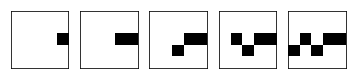

In [36]:
size = 5
frames, right = build_frames(size)
# plot all frames
pyplot.figure()
for i in range(size):
    print(frames[i])
    # create a gray scale subplot for each frame
    pyplot.subplot(1, size, i+1) 
    pyplot.imshow(frames[i], cmap='Greys') 
    # turn of the scale to make it clearer 
    ax = pyplot.gca() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)
# show the plot
pyplot.show()

* Generate multiple sequences of frames and reshape for network input

In [37]:
def generate_examples(size, n_patterns):
  X, y = list(), list()
  for _ in range(n_patterns):
    frames, right = build_frames(size)
    X.append(frames)
    y.append(right)
  # resize as [samples, timesteps, width, height, channels]
  X = array(X).reshape(n_patterns, size, size, size, 1)
  y = array(y).reshape(n_patterns, 1)
  return X, y

### Model

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed

In [39]:
# define the model
model = Sequential()
# configure problem
size = 50
             

model.add(TimeDistributed(Conv2D(2, (2,2),
                          activation='relu'),
                          input_shape=(None,size,size,1)))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(50))

model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy',\
              optimizer='adam', \
              metrics=['acc']) 


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, None, 49, 49, 2)   10        
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 24, 24, 2)   0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 1152)        0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                240600    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 240,661
Trainable params: 240,661
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# fit model
X, y = generate_examples(size, 500)
model.fit(X, y, batch_size=32, epochs=10)

Epoch 1/10
500/500 [==============================] - 7s - loss: 0.6910 - acc: 0.5400     
Epoch 2/10
500/500 [==============================] - 6s - loss: 0.4606 - acc: 0.8460     
Epoch 3/10
500/500 [==============================] - 6s - loss: 0.0647 - acc: 0.9940     
Epoch 4/10
500/500 [==============================] - 6s - loss: 0.2872 - acc: 0.9360     
Epoch 5/10
500/500 [==============================] - 6s - loss: 0.0821 - acc: 0.9860     
Epoch 6/10
500/500 [==============================] - 6s - loss: 0.0296 - acc: 1.0000     
Epoch 7/10
500/500 [==============================] - 6s - loss: 0.0118 - acc: 1.0000     
Epoch 8/10
500/500 [==============================] - 6s - loss: 0.0063 - acc: 1.0000     
Epoch 9/10
500/500 [==============================] - 6s - loss: 0.0109 - acc: 0.9980     
Epoch 10/10
500/500 [==============================] - 6s - loss: 0.0035 - acc: 1.0000     


In [41]:
# evaluate model
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0) 
print('loss: %f, acc: %f' % (loss, acc*100))

loss: 0.003618, acc: 100.000000


In [42]:
# prediction on new data
X, y = generate_examples(size, 1)
yhat = model.predict_classes(X, verbose=0)
expected = "Right" if y[0]==1 else "Left"
predicted = "Right" if yhat[0]==1 else "Left" 
print('Expected: %s, Predicted: %s' % (expected, predicted))

Expected: Left, Predicted: Left
